In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import numpy as np
import matplotlib.pylab as plt

from future_features import tape
from mapper import Mapper

from testsuite import *

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __

In [2]:
N = 10000
Ntest = 10000

n_features = 2
n_components = 4
n_restarts = 1
n_datasets = 1
deviations = np.logspace(-3,1,5, dtype='float32')

In [3]:
deviations = deviations[-1:] # take a large-variance prior on the cluster means, i.e. spread-out clusters, i.e. high snr

In [4]:
mixture_component_covariances_cholesky_df = .1
mixture_component_covariances_cholesky_scale_tril = (1./(mixture_component_covariances_cholesky_df - n_features - 1.))*tf.eye(n_features)

In [30]:
models = []
#models.append(Mapper(centeredIndependentFactorAnalysis, 'cifa', observed_variable_names=['data'], n_observations=N, n_components_in_mixture = 2, n_sources=2, n_features=n_features))
models.append(Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=N, n_components=n_components, n_features=n_features, mixture_component_covariances_cholesky_scale_tril= mixture_component_covariances_cholesky_scale_tril))        
model_names = [model.model_name for model in models]

#test_models = [centeredIndependentFactorAnalysisTest,mixtureOfGaussiansTest]
test_models = [mixtureOfGaussiansTest]
train_neg_log_lik_op = []
test_neg_log_lik_op = []
data_train = tf.placeholder(shape=(N,n_features), dtype='float32') 
data_test = tf.placeholder(shape=(Ntest,n_features), dtype='float32')
for model, test_model in zip(models, test_models):
    train_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_train))
    test_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_test))
ica_directions = tf.placeholder(shape=(2,n_features), dtype='float32')
#assign_defaults = [None]
#assign_defaults[0] = models[0].assigner(data_std=1e-3*tf.ones((1,n_features)), factor_loadings=ica_directions)
#assign_defaults[0] = models[0].assigner(mixture_component_covariances_cholesky=10*tf.tile(tf.eye(n_features)[None],[4,1,1]))

train_neg_log_joint = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
train_neg_log_lik = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
test_neg_log_lik = xr.DataArray(np.zeros((len(models), len(deviations), n_restarts, n_datasets)),dims=['model', 'deviation', 'restart', 'dataset'], coords={'model': model_names, 'deviation': deviations, 'restart': range(n_restarts), 'dataset': range(n_datasets)})
MAP_parameters = {}
placeholder_deviation = tf.placeholder(dtype='float32')
fica = FastICA(n_components=2)
            
with tape() as reference_tf:
    data_tf = mixtureOfGaussians(n_observations=N + Ntest, n_components=4, n_features=n_features, mixture_component_means_std=placeholder_deviation)
        
with tf.Session() as sess:
    for deviation in deviations:
        for dataset in range(n_datasets):
            data, reference = sess.run([data_tf, reference_tf], feed_dict={placeholder_deviation: deviation})
            
            loss = {}
            opt = {}
            for model in models: 
                loss[model.model_name], opt[model.model_name] = model.map_optimizer(data=data[:N])
                
            for restart in range(n_restarts):        
                sess.run(tf.global_variables_initializer())
                sess.run(assign_defaults, feed_dict={ica_directions: fica.fit_transform(data.T).T})
                for i,model in enumerate(models): 
                    opt[model.model_name].minimize()
                    MAP_parameter, converged_loss = sess.run([model.variables, loss[model.model_name]])
                    MAP_parameters[(model.model_name, deviation, restart, dataset)] = MAP_parameter
                    train_neg_log_joint.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = converged_loss
                    train_neg_log_lik.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = sess.run(train_neg_log_lik_op[i], feed_dict={data_train: data[N:]}) #neg_log_lik(model.variables,test_models[i],sess,data[:N])
                    test_neg_log_lik.loc[{'model': model.model_name, 'deviation': deviation, 'restart': restart, 'dataset': dataset}] = sess.run(test_neg_log_lik_op[i], feed_dict={data_test: data[:N]})#neg_log_lik(model.variables,test_models[i],sess,data[N:])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62469.121094
  Number of iterations: 35
  Number of functions evaluations: 58


In [31]:
MAP_parameter

{'mixture_weights': array([1.0680492e-05, 9.9996889e-01, 1.0473763e-05, 9.9067456e-06],
       dtype=float32),
 'mixture_component_means': array([[-1.2759382e-01,  8.2584828e-02],
        [ 5.7679791e+00, -5.3623958e+00],
        [-1.3434666e-01, -2.4784300e-03],
        [-1.0457346e-01, -1.2813824e-01]], dtype=float32),
 'mixture_component_covariances_cholesky': array([[[ 2.7472225e-01,  0.0000000e+00],
         [-4.1358708e-04,  3.4213614e-01]],
 
        [[ 6.8174734e+00,  0.0000000e+00],
         [ 8.0814886e-01,  4.1911230e+00]],
 
        [[ 2.7322644e-01,  0.0000000e+00],
         [-1.7785183e-03,  3.4213752e-01]],
 
        [[ 2.7501455e-01,  0.0000000e+00],
         [-1.0311576e-04,  3.4213609e-01]]], dtype=float32)}

In [32]:
mapmog = MAP_model(MAP_parameter,mixtureOfGaussiansTest,Ntest)

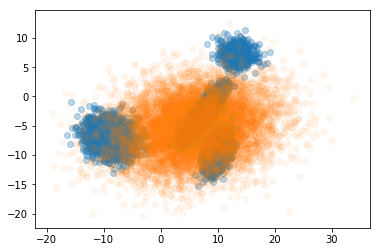

In [34]:
with tf.Session() as sess:
    plt.scatter(*data[Ntest:].T,alpha=.3)
    plt.scatter(*mapmog.distribution.sample(Ntest).eval().T,alpha=.06)